# Project 3: Topic Classification using Naive Bayes

**Solution**

# Intro
---
In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively **dense** (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively **sparse** (represented as a **bag-of-words**). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

The `sklearn` documentation on feature extraction may be useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on Slack, but <b> please prepare your own write-up with your own code. </b>

## Grading
---
- Make sure to answer every part in every question.
 - There are 7 questions and one extra credit question. 
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean and well commented, 
   - and if the functions or answers are too long.

 ## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).



In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [360]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)
print('train data length:', len(train_data))

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
train data length: 2034


### Question 1: Examining your data
---

 1. For each of the first 5 training examples, print the text of the message along with the label (checkout newsgroups_train.target_names).

In [441]:
def Q1(num_examples=5):
    ### STUDENT START ###
    for i in range(num_examples):
        print('The text message reads:', end= ' ')
        print(train_data[i])
        print('The label is:')
        if train_labels[i] == 0:
            print('alt.atheism')
        if train_labels[i] == 1:
            print('comp.graphics')
        if train_labels[i] == 2:
            print('sci.space')
        if train_labels[i] == 3:
            print('talk.religion.misc')
        print('-----------------------------------------------------')
    ### STUDENT END ###

Q1(5)

The text message reads: Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
The label is:
comp.graphics
-----------------------------------------------------
The text message reads: 

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes lik

### Question 2: Text representation
---

1. Transform the training data into a matrix of **word** unigram feature vectors.
  1. What is the size of the vocabulary? 
  1. What is the average number of non-zero features per example?  
  1. What is the fraction of the non-zero entries in the matrix?  
  1. What are the 0th and last feature strings (in alphabetical order)?
  - _Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors restricting to the vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. 
  1. What is the average number of non-zero features per example?
  - _Use `CountVectorization(vocabulary=...)` and its `.transform` method._
1. Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  
  1. What is the size of the vocabulary?
  - _Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  
  1. What is the size of the vocabulary?<br/>
  - _Use `CountVectorization(min_df=...)` and its `.fit_transform` method._
1. Now again transform the training data into a matrix of **word** unigram feature vectors. 
 1. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?
 - _Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. 

In [467]:
def Q2():
    ### STUDENT START ###
    
    ##Part 1##
    #1-A
    vector_train = CountVectorizer()
    X = vector_train.fit_transform(train_data)
    print(X.shape)
    print("1A. The size of the vocabulary is", X.shape[1])
    
    #Count avg number of nonzero features per example
    total = 0
    for i in range(2034):
        total += X[i].nnz
    print("1B. The avg number of nonzero features per example is:", (total/2034))
    
    #Fraction of nonzero entrees in matrix
    #Total entrees of matrix
    total_entrees = 2034*26879 
    count = 0
    print("1C. The fraction of nonzero entrees in matrix is:" , ((total) / total_entrees))
    
    #0th and last feature string
    vector_train.get_feature_names().sort()
    print("1D. The 0th string is:", vector_train.get_feature_names()[0])
    print("1D. The last string is:", vector_train.get_feature_names()[len(vector_train.get_feature_names()) - 1])
    print("-----------------")
    
    ##Part 2##
    vector_train_vocab = CountVectorizer(vocabulary =  ["atheism", "graphics", "space", "religion"])
    X_mini = vector_train_vocab.transform(train_data)
    print("2. The vocab with four words is of size:", X_mini.shape[1])
    
    #Count avg number of nonzero features per example
    total = 0
    for i in range(2034):
        total += X_mini[i].nnz
    print("2A. The avg number of nonzero features when our vocab is 4 words is:",  (total/2034))
    print("-----------------")

    
    ## Part 3 ##
    vector_char_bitri = CountVectorizer(analyzer= 'char', ngram_range = (2,3))
    s = vector_char_bitri.fit_transform(train_data)
    print("3. The size of the vocabulary of bigram and trigram characters is:" , s.shape[1])
    print("-----------------")
    
    ## Part 4 ##
    word_uni = CountVectorizer(analyzer= 'word', min_df = 10)
    trans_word_uni = word_uni.fit_transform(train_data)
    print("Part 4: The size of the vocabulary of unigram words that appear at least 10 times is:" , trans_word_uni.shape[1])
    print("-----------------")
    
    ## Part 5 ##
    word_uni = CountVectorizer(analyzer= 'word')
    trans_word_uni_train = word_uni.fit_transform(train_data)
    trans_word_uni_dev   = word_uni.fit_transform(dev_data)
    print("Part 5: Fraction of words in dev data compared to train data:" ,trans_word_uni_dev.shape[1]/trans_word_uni_train.shape[1])

    
    ### STUDENT END ###

Q2()


(2034, 26879)
1A. The size of the vocabulary is 26879
1B. The avg number of nonzero features per example is: 96.70599803343165
1C. The fraction of nonzero entrees in matrix is: 0.0035978272269590263
1D. The 0th string is: 00
1D. The last string is: zyxel
-----------------
2. The vocab with four words is of size: 4
2A. The avg number of nonzero features when our vocab is 4 words is: 0.26843657817109146
-----------------
(2034, 35478)
3. The size of the vocabulary of bigram and trigram characters is: 35478
-----------------
Part 4: The size of the vocabulary of unigram words that appear at least 10 times is: 3064
-----------------
Part 5: Fraction of words in dev data compared to train data: 0.604412366531493


### Question 3: Initial model evaluation
---

1. Transform the training and development data to matrices of word unigram feature vectors.
1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score. 
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.
1. Why doesn't k-Nearest Neighbors work well for this problem?
1. Why doesn't Logistic Regression work as well as Naive Bayes does?
1. What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

Accuracy for k = 1  neighbors is 0.3831360946745562
The F1 score for k = 1  is: 0.38576918749596
 
Accuracy for k = 2  neighbors is 0.39644970414201186
The F1 score for k = 2  is: 0.4123572842396068
 
Accuracy for k = 3  neighbors is 0.41420118343195267
The F1 score for k = 3  is: 0.41998734432014306
 
Accuracy for k = 4  neighbors is 0.3949704142011834
The F1 score for k = 4  is: 0.38681802901761536
 
Accuracy for k = 5  neighbors is 0.42307692307692313
The F1 score for k = 5  is: 0.4173931225320104
 
Accuracy for k = 6  neighbors is 0.4423076923076923
The F1 score for k = 6  is: 0.43795033052862514
 
Accuracy for k = 7  neighbors is 0.44378698224852076
The F1 score for k = 7  is: 0.4370948644358654
 
Accuracy for k = 8  neighbors is 0.44082840236686394
The F1 score for k = 8  is: 0.4346732235629169
 
Accuracy for k = 9  neighbors is 0.4304733727810651
The F1 score for k = 9  is: 0.42438012794232743
 
 
k = 7 gives the highest F1 score (.44) 
----------------------------------------
A

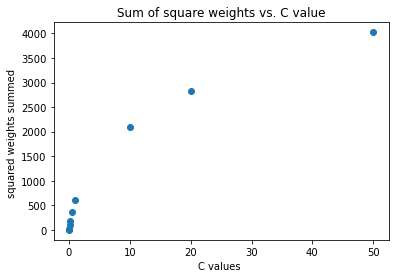

In [453]:
def Q3():
    ### STUDENT START ###
    
    #Part 1 
    count_v = CountVectorizer()
    train_v = count_v.fit_transform(train_data)
    dev_v  = count_v.transform(dev_data)

    #Part 2    
    for k in range(1,10):
        knn = KNeighborsClassifier(n_neighbors = k)
        knn.fit(train_v, train_labels)
        y_pred = knn.predict(dev_v)
        error = (dev_labels != y_pred).sum()/len(y_pred)
        print("Accuracy for k =",k," neighbors is", 1 - error)
        print("The F1 score for k =",k," is:", metrics.f1_score(y_pred, dev_labels, average="weighted"))
        print(" ")
    print(' ')
    print("k = 7 gives the highest F1 score (.44) ")
    print('----------------------------------------')
    
    #Part 3
    alphas = [.001, .01 , .1 , .2, .5, 1, 10,20,50]
    for a in alphas:
        model = MultinomialNB(alpha = a)
        model.fit(train_v, train_labels)
        y_pred = model.predict(dev_v)
        error = (dev_labels != y_pred).sum()/len(y_pred)
        print("Accuracy for alpha =",a,"  is", 1 - error)
        print("The F1 score for alpha =",a," is:", metrics.f1_score(y_pred, dev_labels, average="weighted"))
        print(' ')
    print(' ')
    print("alpha = .1 optimizes the f1 score (.7928) of our alphas")
    print('----------------------------------------')

    
    #Part 4
    weights_sum = []
    for c in alphas:
        model = LogisticRegression(C=c, solver="liblinear", multi_class="auto")
        model.fit(train_v, train_labels)
        y_pred = model.predict(dev_v)
        error = (dev_labels != y_pred).sum()/len(y_pred)
        print("Accuracy for C =",c,"  is", 1 - error)
        print("The F1 score for C =",c," is:", metrics.f1_score(y_pred, dev_labels, average="weighted"))
        print("The sum of squared weights are:", np.square(model.coef_).sum())
        weights_sum.append(np.square(model.coef_).sum())
        print(' ')
    print('----------------------------------------')

    plt.scatter(x = alphas, y = weights_sum)
    plt.xlabel("C values ")
    plt.ylabel("squared weights summed ")
    plt.title("Sum of square weights vs. C value")
    
    
 
    
    ### STUDENT END ###

Q3()

ANSWER:  

Part 5: KNN does not work well for this because distance between words is rather arbitrary or difficult to encompass. For example, what's the distance between "Hello" and "leaf"? I'm sure the model has some way to measure distance but its more difficult to do with categorical data vs. quantitative ones (easy as euclidian distance for a metric).  

For part 6: Logistic Reg doesn't work as well for this type of data as Naive Bayes because it is prone to overfitting with a large set of featues (aka the vocabulary). Naive Bayes does not have this issue and works fine with many words.

Part 7: There seems to be a non-linear correlation between C values and the weighted sum squares. As C increases so does weighted sums. It does seem like it slows down how much higher the weights go like a logarithm pattern

### Question 4: Feature exploration
---

1. Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.
1. For each topic, find the 5 features with the largest weights (not absolute value). If there are no overlaps, you can expect 20 features in total.
1. Show a 20 row (features) x 4 column (topics) table of the weights. So, for each of the features (words) found, we show their weight for all topics.
1. Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value. 


In [459]:
def Q4():
    ### STUDENT START ###
    
    ### Part 1
    
    #initialize countVector and transform data
    vec = CountVectorizer(analyzer = 'word' , ngram_range = (2,2))
    matrix_bi = vec.fit_transform(train_data)
    
    #Logistic Model, train, and accuracy
    model = LogisticRegression(C = .5, solver = "liblinear", multi_class = "auto")
    model.fit(matrix_bi, train_labels)
    
    ### Part 2
    count = 1
    top5_features_label_1 = []
    top5_features_label_2 = []
    top5_features_label_3 = []
    top5_features_label_4 = []
    top5_features = [top5_features_label_1,top5_features_label_2,top5_features_label_3,top5_features_label_4]
    
    #Record the coefficients with the largest weights then select top 5 for each feature
    for coef in model.coef_:
        # sort indecies from index that returns smallest value to index the returns highest value
        indexs = coef.argsort()
        top5_features[count - 1].append(list(indexs[:5:-1][:5]))
        count += 1
        print(' ')
    
    #get features of each topic:
    count = 0
    for topic in top5_features:
        count += 1
        print("For topic",count," the top 5 features are:")
        for word in topic[0]:
            print(list(vec.vocabulary_.keys())[list(vec.vocabulary_.values()).index(word)])
        print(' ')
        
    ### Part 3
    features = ['claim that', 'cheers kent','was just','you are','are you',
               'looking for','in advance','comp graphics','out there','is there',
                'the space','the moon','sci space','and such','it was',
                'the fbi','cheers kent','ignorance is','but he','of jesus']
    coef_of_topic_1 = []
    coef_of_topic_2 = []
    coef_of_topic_3 = []
    coef_of_topic_4 = []
    
    #having found the indeces where we have largest weights, we go ahead and put them into our lists above
    for index in [ 38326,  37174, 184771, 193317,  20596]:
        coef_of_topic_1.append(model.coef_[0][index])
        coef_of_topic_2.append(model.coef_[1][index])
        coef_of_topic_3.append(model.coef_[2][index])
        coef_of_topic_4.append(model.coef_[3][index])
    
    for index in [ 98723,  81950,  40451, 123709,  88596]:
        coef_of_topic_1.append(model.coef_[0][index])
        coef_of_topic_2.append(model.coef_[1][index])
        coef_of_topic_3.append(model.coef_[2][index])
        coef_of_topic_4.append(model.coef_[3][index])
    
    for index in [167336, 165984, 145068,  16732,  90070]:
        coef_of_topic_1.append(model.coef_[0][index])
        coef_of_topic_2.append(model.coef_[1][index])
        coef_of_topic_3.append(model.coef_[2][index])
        coef_of_topic_4.append(model.coef_[3][index])
    
    for index in [164806,  37174,  80535,  32640, 116318]:
        coef_of_topic_1.append(model.coef_[0][index])
        coef_of_topic_2.append(model.coef_[1][index])
        coef_of_topic_3.append(model.coef_[2][index])
        coef_of_topic_4.append(model.coef_[3][index])
    
    #turn lists into series and then print dataframe
    df = pd.DataFrame(list(zip(coef_of_topic_1, coef_of_topic_2,coef_of_topic_3,coef_of_topic_4)),
               columns = categories, index = features)
        
    print(df)
    ### STUDENT END ###
    
Q4()

 
 
 
 
For topic 1  the top 5 features are:
claim that
cheers kent
was just
you are
are you
 
For topic 2  the top 5 features are:
looking for
in advance
comp graphics
out there
is there
 
For topic 3  the top 5 features are:
the space
the moon
sci space
and such
it was
 
For topic 4  the top 5 features are:
the fbi
cheers kent
ignorance is
but he
of jesus
 
               alt.atheism  talk.religion.misc  comp.graphics  sci.space
claim that        0.605549           -0.199042      -0.274383  -0.140369
cheers kent       0.555719           -0.697903      -0.663776   0.534812
was just          0.482050           -0.131419      -0.128862  -0.227465
you are           0.472741           -0.279913      -0.481426   0.028367
are you           0.446954           -0.248257      -0.097166  -0.305622
looking for      -0.630341            1.108366      -0.499926  -0.571863
in advance       -0.459351            0.832568      -0.438488  -0.418455
comp graphics    -0.292166            0.801202      -0

ANSWER: 
_Yeah it's a little interesting that the feature comp graphics is highly correlated with religion talk but almost the opposite with comp graphics itself... Also funny that jesus is higher correlated with sci.space than with religion or atheism! "but he" is weirdly an outlier in sci.space. Sounds like a lot of excuses for men in sci-fi_

### Question 5: Pre-processing for text
---

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

1. Produce a Logistic Regression model (with no preprocessing of text). **Note that you may need to override the "default" preprocessing with an identity function**. Evaluate and show its f1 score and size of the dictionary.
1. Produce an improved Logistic Regression model by preprocessing the text. Evaluate and show its f1 score and size of the vocabulary.  Aim for an improvement in f1 score of 0.02. **Note: this is actually very hard**.
1. How much did the improved model reduce the vocabulary size?

Notes:
* Things you can try: ** ???: Anything else we can suggest** 
 - Look at default pre-processing done.
 - Removing stop words.
 - Experiment with different ways of getting rid of apostrophe's such as replacing them with spaces or with empty strings.
  - Lower casing.
  - Including both lowercase and original case versions of a word.
  - nltk functions such as stemming.
* Train on the "transformed" training data, the data after you applied pre-processing.
* Evaluate on the transformed development data. Note that you never want to "learn" anything from the dev data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.
* The order you apply pre-processing may produce different results.


In [438]:
def Q5():
    ### STUDENT START ###
    ## Part 1: No Preprocess text
    
    def identity(x):
        """ Is a simple identity function"""
        return x
    
    #models 
    vec = CountVectorizer(preprocessor=identity)
    matrix_train = vec.fit_transform(train_data)
    matrix_dev   = vec.transform(dev_data)
    model = LogisticRegression(C = .5 , solver = "liblinear" , multi_class = 'auto')
    model.fit(matrix_train, train_labels)
    
    # F1 score with no-preprocess
    y_pred = model.predict(matrix_dev)
    print("The F1 score with no preprocessing is:", metrics.f1_score(y_pred, dev_labels, average="weighted"))
    print("The size of the vocabulary is:", matrix_dev.shape[1])
    print(' ')
    
    # default preprocessing and its F1 score
    vec = CountVectorizer()
    matrix_train = vec.fit_transform(train_data)
    matrix_dev   = vec.transform(dev_data)
    model = LogisticRegression(C = .5 , solver = "liblinear" , multi_class = 'auto')
    model.fit(matrix_train, train_labels)
    
    y_pred = model.predict(matrix_dev)
    print("The F1 score with default preprocessing is:", metrics.f1_score(y_pred, dev_labels, average="weighted"))
    print("The size of the vocabulary is:", matrix_dev.shape[1])
    print(' ')
    
    # Custom preprocessing
    bad_words = ["my", "myself", "we", "our", "ourselves", "you", "you’re", "you’ve",
                 "too", "very","ok","okay"]
    def process_text(string):
        #make lower case
        string = string.lower()
        #remove apostrophes and periods
        string = string.replace("'", "")
        #remove download
        nltk.download('wordnet', quiet = True)
        #remove characters not in alphabet
        string = re.sub("[^A-Za-z]+"," ", string)
        return string
        
    vec = CountVectorizer(preprocessor=process_text, stop_words=bad_words)
    matrix_train = vec.fit_transform(train_data)
    matrix_dev   = vec.transform(dev_data)
    model = LogisticRegression(C = .5 , solver = "liblinear" , multi_class = 'auto')
    model.fit(matrix_train, train_labels)
    
    y_pred = model.predict(matrix_dev)
    print("The F1 score with process_text  is:", metrics.f1_score(y_pred, dev_labels, average="weighted"))
    print("The size of the vocabulary is:", matrix_dev.shape[1])
    print(' ')
    ### STUDENT END ###

Q5()

The F1 score with no preprocessing is: 0.7161660045275731
The size of the vocabulary is: 33291
 
The F1 score with default preprocessing is: 0.7218796970690614
The size of the vocabulary is: 26879
 


/Users/alejandropelcastre/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['re', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


The F1 score with process_text  is: 0.723305150431705
The size of the vocabulary is: 24328
 


In the end I was only able to improve f1 score by around 0.01 (still better than default pre-processing) and the vocabulary went from 33,291 down to 26,879 for this improvement. So we removed 6,412 words.

### Question 6: L1 and L2 regularization
---

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, **L1 regularization drives many of the weights to 0, effectively removing unimportant features**. For this reason, we can use it as a way to do "feature selection".

1. For several L1 regularization strengths ...
  1. Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.
  1. Produce a new Logistic Regression model using the reduced vocabulary . For this new model, use an **L2** regularization strength of 0.5.  
  1. Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.
1. Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.
1. How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* No need to apply pre-processing from question 5.
* Train on the transformed (i.e. CountVectorizer) training data.
* Evaluate on the transformed development data (using the CountVectorizer instance you trained on the training data).
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).
* (solver="liblinear" might be needed for it not to crash)

/Users/alejandropelcastre/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Dataframe after dropping all the rows with only zeroes
              0             1         2         3
82     0.000000 -3.365833e-02  0.118674  0.000000
146   -0.233949 -7.424104e-02  0.052253  0.000000
351   -0.618403  0.000000e+00  0.000000  0.000000
581    0.000000 -1.121928e-01  0.000000  0.000000
629    0.000000 -7.052837e-08  0.000000  0.000000
...         ...           ...       ...       ...
26744  0.000000  6.066573e-02  0.000000  0.000000
26756  0.000000  0.000000e+00  0.583351  0.000000
26764  0.039928 -1.205348e-01 -0.035666  0.039196
26768  0.037187 -1.266278e-01 -0.186666  0.159813
26771 -0.122432  0.000000e+00  0.000000  0.868790

[708 rows x 4 columns]
The vocabulary size with L1 regularization is: 708
The F1 score after L1 regularization is : 0.687700393841619
Accuracy is 0.6819526627218935
F1 score with c =  0.01 is: 0.496205945908928
Vocab size with c = 0.01 is: 16
F1 score with c =  0.02 is: 0.6034252147702411
Vocab size with c = 0.02 is: 41
F1 score with c =  0.0

/Users/alejandropelcastre/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


F1 score with c =  0.4 is: 0.6866957888903986
Vocab size with c = 0.4 is: 613


/Users/alejandropelcastre/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


F1 score with c =  0.5 is: 0.6890022291524972
Vocab size with c = 0.5 is: 697


/Users/alejandropelcastre/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


F1 score with c =  1 is: 0.6889446839502084
Vocab size with c = 1 is: 694


/Users/alejandropelcastre/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


F1 score with c =  3 is: 0.687042741263938
Vocab size with c = 3 is: 693
Our original model has f1 score of: 0.687700393841619 and vocab size of:26879


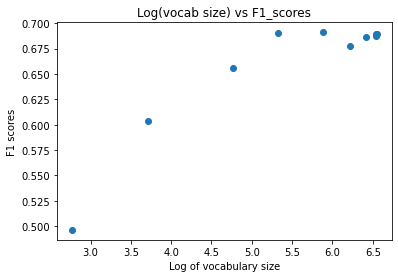

In [452]:
def Q6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###
    
    ### Part 1:A
    
    #initialize models
    count_v = CountVectorizer()
    matrix_train = count_v.fit_transform(train_data)
    model = LogisticRegression(C = .5 , solver = "liblinear" , multi_class = 'auto')
    L1 = LogisticRegression(C = .5,solver = "liblinear", penalty="l1")
    L2 = LogisticRegression(C = .5,solver = "liblinear", penalty="l2")
    L1.fit(matrix_train, train_labels)
    
    # create dataframe with coefficients for each word in each topic after dropping rows with all zeroes
    df = pd.DataFrame((zip(L1.coef_[0],L1.coef_[1],L1.coef_[2],L1.coef_[3])))
    df = df.loc[~(df==0.0).all(axis=1)]
    print("Dataframe after dropping all the rows with only zeroes")
    print(df)
    
    #Get vocab that survived and put into list new_vocabulary
    feature_indeces_that_survive_L1 = list(df.index)
    new_vocabulary = []
    for index in feature_indeces_that_survive_L1:
        new_vocabulary.append(count_v.get_feature_names()[index])
    
    ### Part 1:B
    
    #Initialize models and train
    count_v = CountVectorizer(vocabulary = new_vocabulary)
    matrix_train = count_v.fit_transform(train_data)
    matrix_dev   = count_v.fit_transform(dev_data)
    L2.fit(matrix_train, train_labels)
    y_pred = L2.predict(matrix_dev)
    error = (dev_labels != y_pred).sum()/len(y_pred)
    
    
    ### Part 1:C Get f1 score and vocab size 
    print("The vocabulary size with L1 regularization is:",len(new_vocabulary))
    print("The F1 score after L1 regularization is :", metrics.f1_score(y_pred, dev_labels, average="weighted"))
    print("Accuracy is", 1 - error)
    
    # Part 2
    #get vocab with different values for c
    c_list = [0.01, 0.02, 0.05, 0.1, 0.2,0.3, 0.4, 0.5, 1,3]
    L1 = LogisticRegression(C = .1,solver = "liblinear", penalty="l1")
    L1.fit(matrix_train, train_labels)
    
    f1_scores   = []
    vocab_sizes = []
    
    for c in c_list:
        #Initialize models:
        L1 = LogisticRegression(C = c,solver = "liblinear", penalty="l1")
        L1.fit(matrix_train, train_labels)
        L2.fit(matrix_train, train_labels)
        y_pred = L2.predict(matrix_dev)
        # create dataframe with coefficients for each word in each topic after dropping rows with all zeroes
        df = pd.DataFrame((zip(L1.coef_[0],L1.coef_[1],L1.coef_[2],L1.coef_[3])))
        df = df.loc[~(df==0.0).all(axis=1)]
        #Get vocab that survived and put into list new_vocabulary
        feature_indeces_that_survive_L1 = list(df.index)
        new_vocabulary = []
        for index in feature_indeces_that_survive_L1:
            new_vocabulary.append(count_v.get_feature_names()[index])
        
        #create new CVector with new vocab then train L2 model with it
        count_v_2 = CountVectorizer(vocabulary=new_vocabulary)
        matrix_train_2 = count_v_2.fit_transform(train_data)
        matrix_dev_2   = count_v_2.fit_transform(dev_data)
        L2.fit(matrix_train_2, train_labels)
        y_pred = L2.predict(matrix_dev_2)
        
        #print our results
        print("F1 score with c = ",c,"is:",metrics.f1_score(y_pred, dev_labels, average="weighted"))
        f1_scores.append(metrics.f1_score(y_pred, dev_labels, average="weighted"))
        print("Vocab size with c =",c,"is:", len(new_vocabulary))
        vocab_sizes.append(len(new_vocabulary))
        
    #plot the vocab_size vs. f1_scores in blue and the original f1_score and vocabsize of our original model in red
    plt.scatter(x = np.log(vocab_sizes), y = f1_scores)
    plt.xlabel("Log of vocabulary size")
    plt.ylabel("F1 scores")
    plt.title("Log(vocab size) vs F1_scores")
    original = LogisticRegression(C= .5, solver="liblinear", multi_class="auto")
    original.fit(matrix_train, train_labels)
    y_pred = original.predict(matrix_dev)
    print("Our original model has f1 score of:",metrics.f1_score(y_pred, dev_labels, average="weighted"), 
         "and vocab size of:26879")
    
    ### STUDENT END ###

Q6()

ANSWER:  
_In our original model our f1 score came out to around 0.68770 with the original vocab size of 26879. In our best modified model (After L1 regularization with strength C = 0.2) our highest f1 score came out to be 0.6911 with vocab size of 358. From this we can see that a lot of our original vocab words did not contribute to our model and we had to heavily reduce from over 20,000 words down to a mere 358 to improve f1 score by about .004. This also shows how well our model works with all the vocab words and maybe it's not worth chopping down most of our vocab for a marginal improvement (unless of course every improvement matters). Intresting to note also that our model would need to be tuned in order for the regularization to increase performance, otherwise we risk making it worse_. 

### Question 7: TfIdf
---
As you may recall [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) stands for *term frequency inverse document frequency* and is a way to assign a weight to each word or token signifying their importance for a document in a corpus (a collection of documents).

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

1. How is `TfidfVectorizer` different than `CountVectorizer`?
1. Show the 3 documents with highest R ratio, where ...
  - $R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$
1. Explain what the R ratio describes.
1. What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

In [513]:
def Q7():
    ### STUDENT START ###
    # Produce Logistic Reg model in tf-idf form with L2 reg strength of 100
    tf = TfidfVectorizer()
    train_transform = tf.fit_transform(train_data)
    dev_transform   = tf.transform(dev_data)
    L2 = LogisticRegression(C=100, solver="liblinear", multi_class="auto", penalty="l2")
    L2.fit(train_transform, train_labels)
    y_pred = L2.predict(dev_transform)
    error = (dev_labels != y_pred).sum()/len(y_pred)
    print("Accuracy for tf model is", 1 - error)
    print("F1 score for tf model is",  metrics.f1_score(y_pred, dev_labels, average="weighted"))
    print('--------------------')
    
    #Produce same analysis with CV model
    cv = CountVectorizer()
    train_transform_cv = cv.fit_transform(train_data)
    dev_transform_cv   = cv.transform(dev_data)
    L2 = LogisticRegression(C=100, solver="liblinear", multi_class="auto", penalty="l2")
    L2.fit(train_transform_cv, train_labels)
    y_pred = L2.predict(dev_transform_cv)
    error = (dev_labels != y_pred).sum()/len(y_pred)
    print("Accuracy for countvector model is", 1 - error)
    print("F1 score for countvector model is",  metrics.f1_score(y_pred, dev_labels, average="weighted"))
    print('--------------------')
    
    ### Part 2
    #Get maximum prob and calculate R ratios:
    
    tf = TfidfVectorizer()
    train_transform = tf.fit_transform(train_data)
    dev_transform   = tf.transform(dev_data)
    L2 = LogisticRegression(C=100, solver="liblinear", multi_class="auto", penalty="l2")
    L2.fit(train_transform, train_labels)
    print("transform data shape_train", train_transform.shape)
    maximum = 0
    for doc_prob in L2.predict_proba(dev_transform):
        for topic in doc_prob:
            if maximum <= topic:
                maximum = topic
    print("Maximum predicted prob is ", maximum)
    
    #Now that we have maximum prob, find top 3 documents with highest R ratio
    
    #First find top 3 R ratios
    R_ratios = []
    for doc_prob in L2.predict_proba(dev_transform):
        coef = max(doc_prob)
        R_ratios.append(maximum/coef)
    Rs = R_ratios[:]
    R_sort = R_ratios.sort(reverse = True)
    #print(R_ratios)
    print("The top 3 R ratios are:",R_ratios[:3])
    print("The indexes of those top 1 R ratios is:", Rs.index(3.824212407006125))
    print("The second index is:", Rs.index(3.521249863489014))
    print('----------')
    #Find docs with these R ratios (The third index was the same for the second so could only find 2 docs)
    print("The are the documents with the highest R ratios:")
    print(dev_data[592])
    print(dev_data[17])
    ### STUDENT END ###

Q7()

Accuracy for tf model is 0.7633136094674556
F1 score for tf model is 0.7668609761496009
--------------------
Accuracy for countvector model is 0.6863905325443787
F1 score for countvector model is 0.6899717797268292
--------------------
transform data shape_train (2034, 26879)
Maximum predicted prob is  0.999978716389131
The top 3 R ratios are: [3.824212407006125, 3.521249863489014, 3.521249863489014]
The indexes of those top 1 R ratios is: 592
The second index is: 17
On a more cheerful note, perhaps hackerism/hacking isn't completely dead.

As someone else said, take the GNU offerings for example - free, redistributable and 
often better than the commercial stuff.  Take also the number of papers published
every year in all the fields of computer science - the vast majority of these papers
detail original work of real, often exceptional merit - and the authors are sharing
this knowledge.
 



ANSWER:  
_Part 1_ __The CountVector model actually counts the number of times a word appears in a document. TfIdf on the other hand does not return a count. Instead, tf returns the 'importance' of a word on a scale [0,1] while also taking to account its frequency in other parts of the data. We can also see that with the same parameters, the tf model outperforms the CountVector model in both accuracy and F1 score.__  

_Part 3_ __The R ratio demonstrates which documents have highest difficulty deciding on the label. The closer to 1 the more confident the model is ascribing a label, but the higher away from 1 the R ratio of a document is, the less confident the model is__  

_Part 4_ __It seems that the mistakes are occuring where there's some '-' characters. and also short documents with potentially '/' characters. Short amount of words could make it difficult to decide which label to give and the '-'   could confuse the model

### Question 8 EXTRA CREDIT:
---
Produce a Logistic Regression model to implement your suggestion from Part 7.

In [518]:
 def process_text(string):
        #make lower case
        string = string.lower()
        #remove apostrophes and periods
        string = string.replace("'", "")
        #REPLACE - WITH SPACE
        string = string.replace('-', ' ')
        #REPLACE / with SPACE
        string = string.replace('/',' ')
        #remove download
        nltk.download('wordnet', quiet = True)
        #remove characters not in alphabet
        string = re.sub("[^A-Za-z]+"," ", string)
        return string
    

#logreg without suggestion from part 7
v = CountVectorizer()
train_v = v.fit_transform(train_data)
dev_v   = v.transform(dev_data)

model = LogisticRegression(C=.5, solver="liblinear", multi_class="auto")
model.fit(train_v, train_labels)
y_pred = model.predict(dev_v)
error = (dev_labels != y_pred).sum()/len(y_pred)
print("Orignally without suggestion:")
print("Accuracy for C =",.5,"  is", 1 - error)
print("The F1 score for C =",.5," is:", metrics.f1_score(y_pred, dev_labels, average="weighted"))


#With the preprocessing   
bad_words = ["my", "myself", "we", "our", "ourselves", "you", "you’re", "you’ve",
                 "too", "very","ok","okay"]
vec = CountVectorizer(preprocessor=process_text, stop_words = bad_words)
matrix_train = vec.fit_transform(train_data)
matrix_dev   = vec.transform(dev_data)

model = LogisticRegression(C=.5, solver="liblinear", multi_class="auto")
model.fit(matrix_train, train_labels)
y_pred = model.predict(matrix_dev)
error = (dev_labels != y_pred).sum()/len(y_pred)
print("With suggested preprocessing:")
print("Accuracy for C =",.5,"  is", 1 - error)
print("The F1 score for C =",.5," is:", metrics.f1_score(y_pred, dev_labels, average="weighted"))

Orignally without suggestion:
Accuracy for C = 0.5   is 0.7159763313609467
The F1 score for C = 0.5  is: 0.7218796970690614


/Users/alejandropelcastre/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['re', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


With suggested preprocessing:
Accuracy for C = 0.5   is 0.7174556213017751
The F1 score for C = 0.5  is: 0.723305150431705


In [519]:
pwd

'/Users/alejandropelcastre/Desktop/Data_Science_Projects/w207/cilin-coursework/projects'